# 23장 AI가 문맥을 파악하는 원리

## <목차>

- **23-1. 단어 간 유사성 측정하기**  
- **23-2. 단어들 사이의 관계 파악하기**  
- **23-3. 단어 사이의 관계 수정하기**  
- **23-4. AI가 문맥을 파악하는 법**  
- **23-5. 질문(쿼리), 단서(키), 답변(밸류)**  
- **23-6. 트랜스포머를 위한 어텐션 만들기**  



## 23-1 단어 간 유사성 측정하기

**컴퓨터가 알아 들을 수 있도록 수치 형태로 변환하기**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 단어와 임베딩 벡터 정의
word_embeddings = {
    '귤': np.array([0, 6]),
    '딸기': np.array([0, 5]),
    '수박': np.array([1, 6]),
    '미소짓다': np.array([6, 1]),
    '화내다': np.array([6, 0]),
    '웃다': np.array([5, 0])
}

#출력해 보기
for word, vec in word_embeddings.items():
    print(f"'{word}'의 임베딩 벡터: {vec}")

'귤'의 임베딩 벡터: [0 6]
'딸기'의 임베딩 벡터: [0 5]
'수박'의 임베딩 벡터: [1 6]
'미소짓다'의 임베딩 벡터: [6 1]
'화내다'의 임베딩 벡터: [6 0]
'웃다'의 임베딩 벡터: [5 0]


**단어를 시각화 하기**

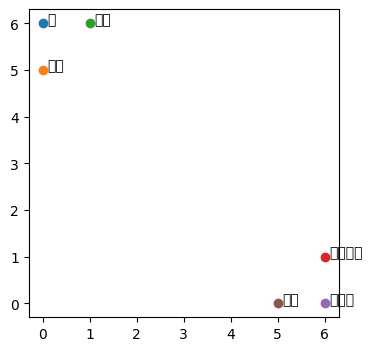

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 단어와 임베딩 벡터 정의
word_embeddings = {
    '귤': np.array([0, 6]),
    '딸기': np.array([0, 5]),
    '수박': np.array([1, 6]),
    '미소짓다': np.array([6, 1]),
    '화내다': np.array([6, 0]),
    '웃다': np.array([5, 0])
}

# 단어 임베딩을 시각화해 봅니다.
plt.figure(figsize=(4, 4))
for word, vec in word_embeddings.items():
    plt.scatter(*vec)
    plt.text(vec[0] + 0.1, vec[1], word)
plt.show()


<주의> 위 그림속 한글이 깨지면, 맨 하단의 [참고] 부분을 참고해 먼저 폰트를 설치하세요.

## 23-2 단어들 사이의 관계 파악하기

**내적 계산하기**

In [8]:
def dot_product(vec1, vec2):
    return np.dot(vec1, vec2)

# 예제 단어들 사이의 내적 계산
print("귤 • 딸기:", dot_product(word_embeddings['귤'], word_embeddings['딸기']))
print("귤 • 웃다:", dot_product(word_embeddings['귤'], word_embeddings['웃다']))



귤 • 딸기: 30
귤 • 웃다: 0


**코사인 유사도 계산하기**

In [10]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

words = list(word_embeddings.keys())
embedding_vectors = np.array(list(word_embeddings.values()))

# 코사인 유사성 계산
similarities = []
for v1 in embedding_vectors:
    row = []
    for v2 in embedding_vectors:
        row.append(cosine_similarity(v1, v2))
    similarities.append(row)

# 결과 출력
for i in range(len(words)):
    for j in range(len(words)):
        print(f"{words[i]} • {words[j]} 유사성: {similarities[i][j]:.2f}")


귤 • 귤 유사성: 1.00
귤 • 딸기 유사성: 1.00
귤 • 수박 유사성: 0.99
귤 • 미소짓다 유사성: 0.16
귤 • 화내다 유사성: 0.00
귤 • 웃다 유사성: 0.00
딸기 • 귤 유사성: 1.00
딸기 • 딸기 유사성: 1.00
딸기 • 수박 유사성: 0.99
딸기 • 미소짓다 유사성: 0.16
딸기 • 화내다 유사성: 0.00
딸기 • 웃다 유사성: 0.00
수박 • 귤 유사성: 0.99
수박 • 딸기 유사성: 0.99
수박 • 수박 유사성: 1.00
수박 • 미소짓다 유사성: 0.32
수박 • 화내다 유사성: 0.16
수박 • 웃다 유사성: 0.16
미소짓다 • 귤 유사성: 0.16
미소짓다 • 딸기 유사성: 0.16
미소짓다 • 수박 유사성: 0.32
미소짓다 • 미소짓다 유사성: 1.00
미소짓다 • 화내다 유사성: 0.99
미소짓다 • 웃다 유사성: 0.99
화내다 • 귤 유사성: 0.00
화내다 • 딸기 유사성: 0.00
화내다 • 수박 유사성: 0.16
화내다 • 미소짓다 유사성: 0.99
화내다 • 화내다 유사성: 1.00
화내다 • 웃다 유사성: 1.00
웃다 • 귤 유사성: 0.00
웃다 • 딸기 유사성: 0.00
웃다 • 수박 유사성: 0.16
웃다 • 미소짓다 유사성: 0.99
웃다 • 화내다 유사성: 1.00
웃다 • 웃다 유사성: 1.00


## 23-3 단어 사이의 관계 수정하기

**관계 업데이트**

In [11]:
def update_vector(vector, target_vector, similarity_value, learning_rate):
    new_vector = vector + learning_rate * (target_vector - vector) * similarity_value
    return new_vector

# 기존 딕셔너리에 추가
word_embeddings['사과'] = np.array([3, 3])  # '사과' 초기 값 추가
word_embeddings['과'] = np.array([0, 0])    # '과' 벡터 추가

# 벡터 값 가져오기
귤 = word_embeddings['귤']
사과 = word_embeddings['사과']
과 = word_embeddings['과']

# '귤과 사과' 문장의 각 단어별 코사인 유사도
cosine_귤_사과 = cosine_similarity(귤, 사과)
cosine_과_사과 = cosine_similarity(과, 사과)

# 학습률1의 예
learning_rate1 = 0.47

# '사과' 벡터를 '귤' 쪽으로 업데이트
print(f"업데이트 이전의 사과 벡터 (사과_?): {사과}")
사과_과일 = update_vector(사과, 귤, cosine_귤_사과, learning_rate1)
print(f"업데이트된 사과 벡터 (사과_과일): {사과_과일}")


업데이트 이전의 사과 벡터 (사과_?): [3 3]
업데이트된 사과 벡터 (사과_과일): [2.00297944 3.99702056]


/tmp/ipython-input-4162871368.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


**모두 실행**

/tmp/ipython-input-233880076.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return dot_product / (norm_v1 * norm_v2)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:15

업데이트 이전의 사과 벡터 (사과_?): [3 3]
업데이트된 사과 벡터 (사과_과일): [2.00297944 3.99702056]
업데이트된 사과 벡터 (사과_행위): [3.99067604 2.00932396]


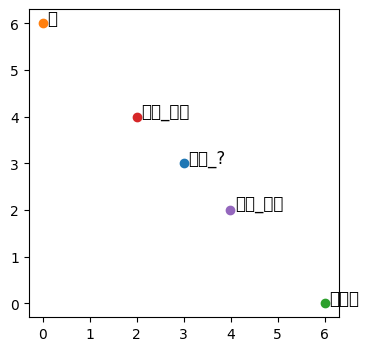

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 초기 벡터값 설정
사과 = np.array([3, 3])
귤 = np.array([0, 6])
과 = np.array([0, 0])
을 = np.array([0, 0])
어제일 = np.array([6, 0])

def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

def update_vector(vector, target_vector, similarity_value, learning_rate):
    new_vector = vector + learning_rate * (target_vector - vector) * similarity_value
    return new_vector

# '귤과 사과' 문장의 각 단어별 코사인 유사도
cosine_귤_사과 = cosine_similarity(귤, 사과)
cosine_과_사과 = cosine_similarity(과, 사과)

# 학습률1을 설정하겠습니다.
learning_rate1 = 0.47

# '사과' 벡터를 '귤' 쪽으로 업데이트
print(f"업데이트 이전의 사과 벡터 (사과_?): {사과}")
사과_과일 = update_vector(사과, 귤, cosine_귤_사과, learning_rate1)
print(f"업데이트된 사과 벡터 (사과_과일): {사과_과일}")

# '어제일을 사과' 문장의 각 단어별 코사인 유사도
cosine_어제일_사과 = cosine_similarity(어제일, 사과_과일)
cosine_을_사과 = cosine_similarity(을, 사과_과일)

# 학습률2를 설정하겠습니다.
learning_rate2 = 1.11

# '사과' 벡터를 '어제일' 쪽으로 업데이트
사과_행위 = update_vector(사과_과일, 어제일, cosine_어제일_사과, learning_rate2)
print(f"업데이트된 사과 벡터 (사과_행위): {사과_행위}")

# 단어 임베딩 시각화
word_embeddings = {
    "사과_?": 사과,
    "귤": 귤,
    "어제일": 어제일,
    "사과_과일": 사과_과일,
    "사과_행위": 사과_행위
}

plt.figure(figsize=(4, 4))
for word, vec in word_embeddings.items():
    plt.scatter(*vec)
    plt.text(vec[0] + 0.1, vec[1], word, fontsize=12)

plt.show()


## 23-4 AI가 문맥을 파악하는 법

**임베딩 행렬의 형태**

In [13]:
# import numpy as np

# 단어와 해당 임베딩 벡터를 딕셔너리로 정의합니다.
# 실제로는 사전 훈련된 임베딩 벡터를 사용하는 것이 일반적입니다.
embedding_dict = {
    '커피': np.random.rand(512),
    '한잔': np.random.rand(512),
    '어때': np.random.rand(512),
    'PAD': np.zeros(512)  # 패딩 벡터는 0으로 채웁니다.
}

# 입력 문장
sentence = ['커피', '한잔', '어때']
max_len = 4  # 최대 문장 길이
tokens = sentence + ['PAD'] * (max_len - len(sentence))  # 패딩 적용

# 토큰을 임베딩 벡터로 변환
embeddings = np.array([embedding_dict[token] for token in tokens])
print("임베딩 행렬의 형태:", embeddings.shape)  # (4, 512)


임베딩 행렬의 형태: (4, 512)


**각 헤드의 형태**

In [14]:
num_heads = 8
head_dim = 512 // num_heads  # 각 헤드의 차원

# 임베딩을 8개의 헤드로 분할
heads = np.split(embeddings, num_heads, axis=1)
print("각 헤드의 형태:", heads[0].shape)  # (4, 64)


각 헤드의 형태: (4, 64)


**내적 결과 행렬의 형태**

In [15]:
# 첫 번째 헤드 선택
head_1 = heads[0]

# 복사1과 복사2 생성
copy1 = head_1
copy2 = head_1.T

# 내적 계산
attention_scores = np.dot(copy1, copy2)
print("내적 결과 행렬의 형태:", attention_scores.shape)  # (4, 4)


내적 결과 행렬의 형태: (4, 4)


**복원된 헤드의 형태**

In [16]:
# 복사3 생성
copy3 = embeddings[:, :head_dim]

# 다시 4x64 형태로 변환
restored_head = np.dot(attention_scores, copy3)
print("복원된 헤드의 형태:", restored_head.shape)  # (4, 64)


복원된 헤드의 형태: (4, 64)


**최종 출력 행렬의 형태**

In [17]:
restored_heads = []

for i in range(num_heads):
    head = heads[i]
    copy1 = head
    copy2 = head.T
    attention_scores = np.dot(copy1, copy2)
    copy3 = embeddings[:, i*head_dim:(i+1)*head_dim]
    restored_head = np.dot(attention_scores, copy3)
    restored_heads.append(restored_head)

# 모든 헤드를 결합하여 원래 차원으로 복원
final_output = np.concatenate(restored_heads, axis=1)
print("최종 출력 행렬의 형태:", final_output.shape)  # (4, 512)


최종 출력 행렬의 형태: (4, 512)


**전체 실행**

In [18]:
import numpy as np

# 단어와 해당 임베딩 벡터를 딕셔너리로 정의합니다.
embedding_dict = {
    '커피': np.random.rand(512),
    '한잔': np.random.rand(512),
    '어때': np.random.rand(512),
    'PAD': np.zeros(512)  # 패딩 벡터는 0으로 채웁니다.
}

# 입력 문장
sentence = ['커피', '한잔', '어때']
max_len = 4  # 최대 문장 길이
tokens = sentence + ['PAD'] * (max_len - len(sentence))  # 패딩 적용

# 토큰을 임베딩 벡터로 변환
embeddings = np.array([embedding_dict[token] for token in tokens])
print("임베딩 행렬의 형태:", embeddings.shape)  # (4, 512)

# 임베딩을 8개의 헤드로 분할
num_heads = 8
head_dim = 512 // num_heads  # 각 헤드의 차원

# 임베딩을 8개의 헤드로 분할
heads = np.split(embeddings, num_heads, axis=1)
print("각 헤드의 형태:", heads[0].shape)  # (4, 64)

# 각 헤드간의 내적 계산 및 복원
restored_heads = []

for i in range(num_heads):
    head = heads[i] # i번째 헤드 선택
    copy1 = head # 첫 번째 복사본
    copy2 = head.T # 두 번째 복사본 (전치)
    attention_scores = np.dot(copy1, copy2) # 내적 계산 (4x4 행렬)
    copy3 = embeddings[:, i*head_dim:(i+1)*head_dim] # 복사3 생성 (4x64)
    restored_head = np.dot(attention_scores, copy3) #내적 결과와 복사3을 곱하여 복원 (4x64)
    restored_heads.append(restored_head) # 복원된 헤드를 리스트에 추가

# 모든 헤드를 결합하여 원래 차원으로 복원
final_output = np.concatenate(restored_heads, axis=1)
print("최종 출력 행렬의 형태:", final_output.shape)  # (4, 512)


임베딩 행렬의 형태: (4, 512)
각 헤드의 형태: (4, 64)
최종 출력 행렬의 형태: (4, 512)


## 23-5 질문(쿼리), 단서(키), 답변(밸류)

**쿼리, 키, 밸류**

In [19]:
# 쿼리, 키, 밸류 행렬 초기화
num_heads = 8
head_dim = 512 // num_heads  # 각 헤드의 차원
heads = np.split(embeddings, num_heads, axis=1)
queries = heads.copy()
keys = [head.T for head in heads]
values = heads.copy()

print("쿼리 행렬의 형태:", queries[0].shape)  # (4, 64)
print("키 행렬의 형태:", keys[0].shape)  # (64, 4)
print("밸류 행렬의 형태:", values[0].shape)  # (4, 64)


쿼리 행렬의 형태: (4, 64)
키 행렬의 형태: (64, 4)
밸류 행렬의 형태: (4, 64)


**스케일링 전 어텐션 스코어**

In [20]:
# 스케일링 전
attention_scores = np.dot(queries[0], keys[0])
print("스케일링 전 어텐션 스코어:")
print(attention_scores)

# 스케일링을 위한 헤드 차원의 제곱근 계산
scaling_factor = np.sqrt(head_dim)

# 스케일링 후
scaled_attention_scores = attention_scores / scaling_factor
print("스케일링 후 어텐션 스코어:")
print(scaled_attention_scores)


스케일링 전 어텐션 스코어:
[[22.69684904 19.66077324 18.34082907  0.        ]
 [19.66077324 26.93905854 19.75632638  0.        ]
 [18.34082907 19.75632638 21.72272449  0.        ]
 [ 0.          0.          0.          0.        ]]
스케일링 후 어텐션 스코어:
[[2.83710613 2.45759665 2.29260363 0.        ]
 [2.45759665 3.36738232 2.4695408  0.        ]
 [2.29260363 2.4695408  2.71534056 0.        ]
 [0.         0.         0.         0.        ]]


**소프트맥스 적용 후 어텐션 스코어**

In [21]:
# 패딩 부분을 -∞로 채운 마스크 행렬 준비
mask = np.zeros_like(scaled_attention_scores)
mask[:, -1] = -np.inf  # 마지막 열을 패딩 처리
mask[-1, :] = -np.inf  # 마지막 행을 패딩 처리

# 소프트맥스 적용 함수
def masked_softmax(x, mask):
    x_exp = np.exp(x - np.max(x, axis=-1, keepdims=True))  # 오버플로 방지
    x_exp = x_exp * (mask != -np.inf)  # 마스크된 부분은 0으로 처리
    x_sum = np.sum(x_exp, axis=-1, keepdims=True) # 지수 값의 합 계산
    x_sum = np.where(x_sum == 0, 1, x_sum)  # 0으로 나누는 것을 방지하기 위해 합이 0인 경우 1로 설정
    return x_exp / x_sum # 소프트맥스 계산

# 소프트맥스 적용
attention_probs = masked_softmax(scaled_attention_scores, mask)
print("소프트맥스 적용 후 어텐션 스코어:")
print(attention_probs)


소프트맥스 적용 후 어텐션 스코어:
[[0.44163227 0.30216345 0.25620428 0.        ]
 [0.22242953 0.55246827 0.22510219 0.        ]
 [0.26883969 0.32087525 0.41028506 0.        ]
 [0.         0.         0.         0.        ]]


**전체 실행**

In [22]:
import numpy as np

# 전체 출력 형식을 소수점 이하 네 자리로 설정
np.set_printoptions(precision=4, suppress=True)

# 단어와 해당 임베딩 벡터를 딕셔너리로 정의합니다.
embedding_dict = {
    '커피': np.random.rand(512),
    '한잔': np.random.rand(512),
    '어때': np.random.rand(512),
    'PAD': np.zeros(512)  # 패딩 벡터는 0으로 채웁니다.
}

# 입력 문장
sentence = ['커피', '한잔', '어때']
max_len = 4  # 최대 문장 길이
tokens = sentence + ['PAD'] * (max_len - len(sentence))  # 패딩 적용

# 토큰을 임베딩 벡터로 변환
embeddings = np.array([embedding_dict[token] for token in tokens])
print("임베딩 행렬의 형태:", embeddings.shape)  # (4, 512)

# 쿼리, 키, 밸류 행렬 초기화
num_heads = 8
head_dim = 512 // num_heads  # 각 헤드의 차원
heads = np.split(embeddings, num_heads, axis=1)
queries = heads.copy()
keys = [head.T for head in heads]
values = heads.copy()

print("쿼리 행렬의 형태:", queries[0].shape)  # (4, 64)
print("키 행렬의 형태:", keys[0].shape)  # (64, 4)
print("밸류 행렬의 형태:", values[0].shape)  # (4, 64)

# 2. 스케일링 전후의 결과
# 스케일링 전
attention_scores = np.dot(queries[0], keys[0])
print("스케일링 전 어텐션 스코어:")
print(attention_scores)

# 스케일링을 위한 헤드 차원의 제곱근 계산
scaling_factor = np.sqrt(head_dim)

# 스케일링 후
scaled_attention_scores = attention_scores / scaling_factor
print("스케일링 후 어텐션 스코어:")
print(scaled_attention_scores)

# 3. 어텐션 스코어 계산 및 소프트맥스 적용 전후의 결과

# 패딩 부분을 -∞로 채운 마스크 행렬 준비
mask = np.zeros_like(scaled_attention_scores)
mask[:, -1] = -np.inf  # 예시로 마지막 열을 패딩 처리
mask[-1, :] = -np.inf  # 예시로 마지막 행을 패딩 처리

# 소프트맥스 적용 함수
def masked_softmax(x, mask):
    x_exp = np.exp(x - np.max(x, axis=-1, keepdims=True))  # 오버플로 방지
    x_exp = x_exp * (mask != -np.inf)  # 마스크된 부분은 0으로 처리
    x_sum = np.sum(x_exp, axis=-1, keepdims=True)
    x_sum = np.where(x_sum == 0, 1, x_sum)  # 0으로 나누는 것을 방지
    return x_exp / x_sum

# 소프트맥스 적용
attention_probs = masked_softmax(scaled_attention_scores, mask)
print("소프트맥스 적용 후 어텐션 스코어:")
print(attention_probs)

# 복원된 헤드를 저장할 리스트
restored_heads = []

for i in range(num_heads):
    query = queries[i]
    key = keys[i]
    value = values[i]

    # 내적 계산 후 스케일링
    attention_scores = np.dot(query, key) / scaling_factor

    # 패딩 처리
    padding_mask = (np.array(tokens) == 'PAD').astype(float)
    padding_mask = np.tile(padding_mask, (attention_scores.shape[0], 1))
    attention_scores = np.where(padding_mask, -np.inf, attention_scores)

    # 소프트맥스 적용
    attention_weights = masked_softmax(attention_scores, padding_mask)

    # 밸류와의 곱셈
    restored_head = np.dot(attention_weights, value)
    restored_heads.append(restored_head)

# 모든 헤드를 결합하여 원래 차원으로 복원
final_output = np.concatenate(restored_heads, axis=1)
print("최종 출력 행렬의 형태:", final_output.shape)  # (4, 512)


임베딩 행렬의 형태: (4, 512)
쿼리 행렬의 형태: (4, 64)
키 행렬의 형태: (64, 4)
밸류 행렬의 형태: (4, 64)
스케일링 전 어텐션 스코어:
[[22.8752 14.8383 15.1431  0.    ]
 [14.8383 18.2558 14.2206  0.    ]
 [15.1431 14.2206 19.7345  0.    ]
 [ 0.      0.      0.      0.    ]]
스케일링 후 어텐션 스코어:
[[2.8594 1.8548 1.8929 0.    ]
 [1.8548 2.282  1.7776 0.    ]
 [1.8929 1.7776 2.4668 0.    ]
 [0.     0.     0.     0.    ]]
소프트맥스 적용 후 어텐션 스코어:
[[0.5725 0.2097 0.2178 0.    ]
 [0.2891 0.4432 0.2676 0.    ]
 [0.2728 0.243  0.4842 0.    ]
 [0.     0.     0.     0.    ]]
최종 출력 행렬의 형태: (4, 512)


## 23-6 트랜스포머를 위한 어텐션 만들기

**여러 문장의 임베딩**

In [23]:
# 입력 문장
sentences = [
    ['<sos>', '커피', '한잔', '어때', '<eos>'],
    ['<sos>', '오늘', '날씨', '좋네', '<eos>'],
    ['<sos>', '옷이', '어울려요', '<eos>', 'PAD']
]

# 단어와 해당 임베딩 벡터를 딕셔너리로 정의합니다.
embedding_dict = {
    '<sos>': np.random.rand(512),
    '<eos>': np.random.rand(512),
    '커피': np.random.rand(512),
    '한잔': np.random.rand(512),
    '어때': np.random.rand(512),
    '오늘': np.random.rand(512),
    '날씨': np.random.rand(512),
    '좋네': np.random.rand(512),
    '옷이': np.random.rand(512),
    '어울려요': np.random.rand(512),
    'PAD': np.zeros(512)  # 패딩 벡터는 0으로 채웁니다.
}

max_len = 5  # 최대 문장 길이

# 토큰을 임베딩 벡터로 변환
embeddings = np.array([[embedding_dict[token] for token in sentence] for sentence in sentences])
print("임베딩 행렬의 형태:", embeddings.shape)  # (3, 5, 512)


임베딩 행렬의 형태: (3, 5, 512)


**여러 문장에서의 키, 쿼리, 밸류**

In [24]:
# 쿼리, 키, 밸류 행렬 초기화
num_heads = 8
head_dim = 512 // num_heads  # 각 헤드의 차원
heads = np.split(embeddings, num_heads, axis=2) # 512차원 임베딩 벡터를 8개의 헤드로 분할하여 heads에 저장
queries = heads.copy()
keys = [head.transpose(0, 2, 1) for head in heads] # 키 행렬을 각 헤드의 전치를 통해 초기화 (첫 번째 축: 배치 크기, 두 번째 축: 문장 길이, 세 번째 축: 헤드 차원)
values = heads.copy()

print("쿼리 행렬의 형태:", queries[0].shape)  # (3, 5, 64)
print("키 행렬의 형태:", keys[0].shape)  # (3, 64, 5)
print("밸류 행렬의 형태:", values[0].shape)  # (3, 5, 64)


쿼리 행렬의 형태: (3, 5, 64)
키 행렬의 형태: (3, 64, 5)
밸류 행렬의 형태: (3, 5, 64)


**전체 코드**

In [25]:
import numpy as np

# 전체 출력 형식을 소수점 이하 네 자리로 설정
np.set_printoptions(precision=4, suppress=True)

# 단어와 해당 임베딩 벡터를 딕셔너리로 정의합니다.
embedding_dict = {
    '<sos>': np.random.rand(512),
    '<eos>': np.random.rand(512),
    '커피': np.random.rand(512),
    '한잔': np.random.rand(512),
    '어때': np.random.rand(512),
    '오늘': np.random.rand(512),
    '날씨': np.random.rand(512),
    '좋네': np.random.rand(512),
    '옷이': np.random.rand(512),
    '어울려요': np.random.rand(512),
    'PAD': np.zeros(512)  # 패딩 벡터는 0으로 채웁니다.
}

# 입력 문장
sentences = [
    ['<sos>', '커피', '한잔', '어때', '<eos>'],
    ['<sos>', '오늘', '날씨', '좋네', '<eos>'],
    ['<sos>', '옷이', '어울려요', '<eos>', 'PAD']
]
max_len = 5  # 최대 문장 길이

# 토큰을 임베딩 벡터로 변환
embeddings = np.array([[embedding_dict[token] for token in sentence] for sentence in sentences])
print("임베딩 행렬의 형태:", embeddings.shape)  # (3, 5, 512)

# 쿼리, 키, 밸류 행렬 초기화
num_heads = 8
head_dim = 512 // num_heads  # 각 헤드의 차원
heads = np.split(embeddings, num_heads, axis=2)  # 512차원 임베딩 벡터를 8개의 헤드로 분할하여 heads에 저장
queries = heads.copy()
keys = [head.transpose(0, 2, 1) for head in heads]  # 키 행렬을 각 헤드의 전치를 통해 초기화 (첫 번째 축: 배치 크기, 두 번째 축: 문장 길이, 세 번째 축: 헤드 차원)
values = heads.copy()

print("쿼리 행렬의 형태:", queries[0].shape)  # (3, 5, 64)
print("키 행렬의 형태:", keys[0].shape)  # (3, 64, 5)
print("밸류 행렬의 형태:", values[0].shape)  # (3, 5, 64)

# 특정 토큰 (커피, 한잔, 어때)의 인덱스
tokens_of_interest = ['커피', '한잔', '어때']
indices_of_interest = [sentences[0].index(token) for token in tokens_of_interest]

# 어텐션 이전의 임베딩 테이블 중 특정 토큰들의 평균 값 계산
print("어텐션 이전의 임베딩 테이블 중 '커피', '한잔', '어때' 토큰의 평균 값:")
initial_avg = np.mean(embeddings[0, indices_of_interest, :], axis=1)
print(initial_avg)

# 스케일링 및 어텐션 스코어 계산
attention_scores = np.matmul(queries[0], keys[0])
scaling_factor = np.sqrt(head_dim)
scaled_attention_scores = attention_scores / scaling_factor

# 패딩 처리
mask = np.array([[token == 'PAD' for token in sentence] for sentence in sentences])
mask = mask[:, np.newaxis, :]  # 차원을 맞추기 위해 확장
scaled_attention_scores = np.where(mask, -np.inf, scaled_attention_scores)

# 소프트맥스 적용 함수
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

# 복원된 헤드를 저장할 리스트
restored_heads = []

for i in range(num_heads):
    query = queries[i]
    key = keys[i]
    value = values[i]

    # 내적 계산 후 스케일링
    attention_scores = np.matmul(query, key) / scaling_factor

    # 패딩 처리
    mask = np.array([[token == 'PAD' for token in sentence] for sentence in sentences])
    mask = mask[:, np.newaxis, :]  # 차원을 맞추기 위해 확장
    attention_scores = np.where(mask, -np.inf, attention_scores)

    # 소프트맥스 적용
    attention_weights = softmax(attention_scores)

    # 밸류와의 곱셈
    restored_head = np.matmul(attention_weights, value)
    restored_heads.append(restored_head)

# 모든 헤드를 결합하여 원래 차원으로 복원
final_output = np.concatenate(restored_heads, axis=2)

# 어텐션 이후의 결과 중 특정 토큰들의 평균 값 계산
print("어텐션 이후의 결과 중 '커피', '한잔', '어때' 토큰의 평균 값:")
final_avg = np.mean(final_output[0, indices_of_interest, :], axis=1)
print(final_avg)


임베딩 행렬의 형태: (3, 5, 512)
쿼리 행렬의 형태: (3, 5, 64)
키 행렬의 형태: (3, 64, 5)
밸류 행렬의 형태: (3, 5, 64)
어텐션 이전의 임베딩 테이블 중 '커피', '한잔', '어때' 토큰의 평균 값:
[0.4987 0.5045 0.4876]
어텐션 이후의 결과 중 '커피', '한잔', '어때' 토큰의 평균 값:
[0.5021 0.5038 0.5007]


## [참고] 그림 속 폰트가 깨지면 실행하세요.

<1> 아래 코드를 실행해 필요한 폰트를 설치합니다.

In [3]:
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm -rf ~/.cache/matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (43.1 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/

<2> 위 메뉴에서 "런타임 > 세션 다시 시작"을 클릭해서 런타임을 재시작합니다.

<3> 아래 코드를 실행해 설치된 폰트를 확인합니다.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44544 (\N{HANGUL SYLLABLE GEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54256 (\N{HANGUL SYLLABLE PON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

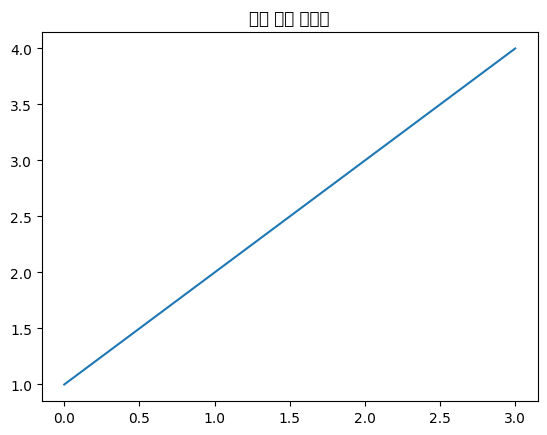

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

plt.plot([1, 2, 3, 4])
plt.title('한글 폰트 테스트')
plt.show()